In [ ]:
import pandas as pd
import networkx as nx
from collections import Counter
#from networkx import louvain_communities

MAIN_TABLE_PATH = r"data\full_table_v2.csv"
OUTPATH = r"data\explorations\city_centralities.csv" #deprecated

df = pd.read_csv(MAIN_TABLE_PATH)

In [2]:
df.columns

Index(['master_id', 'artist_id', 'genre', 'style', 'data_quality_y', 'year',
       'title', 'recorded_id', 'latitude', 'longitude', 'geocoding_method',
       'geometry', 'city', 'est_2010_population', 'max_bb_xma', 'member_ids',
       'artist_name', 'artist_info_data_quality', 'new_style_1',
       'novel_style_combo_count'],
      dtype='object')

In [ ]:
def generate_graph(df, id_var):
    artist_groups = df.groupby(id_var)

    edges = []

    for artist, group in artist_groups:
        # Sort by year for each artist
        group_sorted = group.sort_values('year')
        cities_years = list(zip(group_sorted['city'], group_sorted['year']))
        # Remove consecutive duplicates (artist in same city in consecutive years)
        prev_city, prev_year = None, None
        for i in range(1, len(cities_years)):
            city_a, year_a = cities_years[i-1]
            city_b, year_b = cities_years[i]
            if city_a != city_b:
                if year_a == year_b:
                    # If same year, count both directions
                    edges.append((city_a, city_b))
                    edges.append((city_b, city_a))
                else:
                    # Direction: from earlier city to later city
                    edges.append((city_a, city_b))

    # edge weight
    edge_counts = Counter(edges)

    # Build directed graph
    G = nx.DiGraph()
    for (src, dst), weight in edge_counts.items():
        if src and dst:
            G.add_edge(src, dst, weight=weight)
    return G

    

def get_city_centrality(df, start_year, end_year, id_var):

    df_filtered = df[(df['year'] >= start_year) & (df['year'] < end_year)]
    G = generate_graph(df_filtered, id_var)


        # do it got nodes?
    if len(G.nodes()) == 0:
        return pd.DataFrame(columns=['city', 'betweenness_centrality'])
    
    centrality = nx.betweenness_centrality(G, weight='weight')

    # save table
    centrality_table = pd.DataFrame(list(centrality.items()), columns=['city', 'betweenness_centrality'])
    centrality_table = centrality_table.sort_values('betweenness_centrality', ascending=False).reset_index(drop=True)
    return centrality_table

In [4]:
df_valid = df.dropna(subset=['artist_id', 'city', 'year'])

In [5]:
# Define time windows
start_year = 1930
end_year = int(df['year'].max())
window_size = 10
step = 5

all_centrality_data = []

# Generate time windows and compute centrality
current_start = start_year
while current_start + window_size <= end_year:
    syear = current_start
    fyear = current_start + window_size
    print(syear)

    centrality_frame = get_city_centrality(df_valid, syear, fyear, 'artist_id')
    
    if not centrality_frame.empty:
        centrality_frame['year_range'] = f"{syear}_{fyear}"
        all_centrality_data.append(centrality_frame)
    
    current_start += step


1930
1935
1940
1945
1950
1955
1960
1965
1970
1975
1980
1985
1990
1995
2000
2005
2010
2015


In [ ]:
# Combine all data
if all_centrality_data:
    combined_centrality = pd.concat(all_centrality_data, ignore_index=True) 
    # Reshape so city and year_range are columns
    reshaped_centrality = combined_centrality[['city', 'year_range', 'betweenness_centrality']]
    # Save to file
    reshaped_centrality.to_csv(r"data\total_centrality.csv", index=False)
    print(f"Saved total centrality data to: C:\\Users\\maxmo\\Dropbox\\GDS\\Dissertation\\discogs\\data\\total_centrality.csv")
else:
    print("No centrality data generated - check data or time windows")

Saved total centrality data to: C:\Users\maxmo\Dropbox\GDS\Dissertation\discogs\data\total_centrality.csv


Repeat the above using the 'style tag' to do the edge creation. This gives us a rough indicator of dispersion. This measure is not used in the paper.

In [7]:
all_centrality_data = []

# Generate time windows and compute centrality
current_start = start_year
while current_start + window_size <= end_year:
    syear = current_start
    fyear = current_start + window_size
    print(syear)

    centrality_frame = get_city_centrality(df_valid, syear, fyear, 'style')
    
    if not centrality_frame.empty:
        centrality_frame['year_range'] = f"{syear}_{fyear}"
        all_centrality_data.append(centrality_frame)
    
    current_start += step

1930
1935
1940
1945
1950
1955
1960
1965
1970
1975
1980
1985
1990
1995
2000
2005
2010
2015


In [ ]:
# Combine all data
if all_centrality_data:
    combined_centrality = pd.concat(all_centrality_data, ignore_index=True) 
    # Reshape so city and year_range are columns
    reshaped_centrality = combined_centrality[['city', 'year_range', 'betweenness_centrality']]
    # Save to file
    reshaped_centrality.to_csv(r"data\style_based_centrality.csv", index=False)
    print(f"Saved total centrality data to: C:\\Users\\maxmo\\Dropbox\\GDS\\Dissertation\\discogs\\data\\style_based_centrality.csv")
else:
    print("No centrality data generated - check data or time windows")

In [9]:
from node2vec import Node2Vec

G_styles = generate_graph(df, 'style')
G_artists = generate_graph(df, 'artist_id')

styles_model = Node2Vec(
    G_styles,
    quiet=True,
    weight_key="weight",
    dimensions=2,
    walk_length=10,
    num_walks=10,
    p=1,
    q=2,
)

artists_model = Node2Vec(
    G_artists,
    quiet=True,
    weight_key="weight",
    dimensions=2,
    walk_length=10,
    num_walks=10,
    p=1,
    q=2,
)

c:\Users\maxmo\anaconda3\envs\GRL_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
NUMBER_OF_CLUSTERS = 4

style_model_vectors = styles_model.wv.vectors
kmeans_styles = KMeans(n_clusters=NUMBER_OF_CLUSTERS, random_state=0)
kmeans_styles.fit(style_model_vectors)

#repeat for artists_model


Genre-based centrality build:

This forms part of a genre-segmented analysis that is possible using the city panel file, but is ultimately not done in the main paper. 

In [ ]:
import os

GENRE_OUTDIR = r"data"
os.makedirs(GENRE_OUTDIR, exist_ok=True)

unique_genres = df['genre'].dropna().unique()

for genre in unique_genres:
    print(f"processing genre: {genre}")
    genre_df = df[df['genre'] == genre]
    genre_df_valid = genre_df.dropna(subset=['artist_name', 'city', 'year'])

    all_centrality_data_genre = []
    current_start = start_year
    while current_start + window_size <= end_year:
        syear = current_start
        fyear = current_start + window_size

        centrality_frame = get_city_centrality(genre_df_valid, syear, fyear)
        if not centrality_frame.empty:
            centrality_frame['year_range'] = f"{syear}_{fyear}"
            all_centrality_data_genre.append(centrality_frame)
        current_start += step

    if all_centrality_data_genre:
        combined_centrality_genre = pd.concat(all_centrality_data_genre, ignore_index=True)
        
        # Reshape so city and year_range are columns
        reshaped_centrality_genre = combined_centrality_genre[['city', 'year_range', 'betweenness_centrality']]
        safe_genre = genre.replace('/', '_').replace('\\', '_').replace(' ', '_')
        outpath = os.path.join(GENRE_OUTDIR, f"{safe_genre}_centralities.csv")
        reshaped_centrality_genre.to_csv(outpath, index=False)
        print(f"Saved centrality data for {genre} to: {outpath}")
    else:
        print(f"No centrality data generated for genre: {genre}")

The code below is for demonstration and cool looking graphs only - they are not shown in the final paper nor are they essential to the code build.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

UK_CITIES = uk_cities = [
    'London2', 'Birmingham2', 'Sheffield', 'Reading', 'Manchester2',
    'Glasgow2', 'Southend', 'Coventry', 'Oxford', 'Bradford',
    'Liverpool2', 'Luton', 'Lincoln1', 'Leeds', 'Stoke', 'Nottingham',
    'Bath', 'Blackpool', 'Ipswich', 'Leicester', 'Kingston upon Hull',
    'Bristol2', 'Brighton', 'Inverness', 'Cardiff', 'Edinburgh',
    'Swansea', 'Portsmouth', 'Southampton', 'Norwich', 'Dumfries',
    'York2', 'Aberdeen3', 'Middlesbrough', 'Exeter', 'Plymouth',
    'Peterborough1', 'Londonderry', 'Bournemouth', 'Dundee', 'Belfast'
]


US_cities = us_cities = [
    'Ann Arbor', 'Los Angeles1', 'Minneapolis', 'Nashville',
    'Jacksonville1', 'Chicago', 'Detroit', 'Windsor1', 'New York',
    'Boston', 'Pasadena2', 'San Francisco1', 'Rochester1', 'Newark',
    'Stamford', 'Philadelphia', 'Austin', 'Atlanta', 'New Haven',
    'Alexandria2', 'Washington, D.C.', 'New Orleans',
    'San Diego', 'Oceanside', 'Miami Beach', 'Miami', 'Tampa',
    'Evanston', 'Virginia Beach', 'Norfolk1', 'Orlando', 'Sanford',
    'Palm Springs', 'Ft. Worth', 'Dallas', 'Richmond1', 'Duluth',
    'Dayton', 'Paterson', 'Buffalo', 'Cleveland', 'Worcester1',
    'Sacramento', 'Wilmington1', 'Wilmington2', 'Raleigh', 'Durham',
    'Lowell', 'West Palm Beach', 'Portland2', 'Oakland', 'Berkeley',
    'Baton Rouge', 'Toledo1', 'Denver', 'Pontiac', 'Everett', 'Mesa',
    'Phoenix', 'Irvine', 'Santa Rosa1', 'San Mateo', 'Olympia',
    'Aurora2', 'Elgin', 'San Luis Obispo', 'Cincinnati', 'Indianapolis',
    'Fort Lauderdale', 'Honolulu', 'Hartford', 'Racine', 'Kansas City1',
    'Kansas City2', 'Coral Gables', 'Tyler',
    'Las Vegas2', 'Columbus2', 'Santa Barbara2', 'Colorado Springs',
    'Greensboro', 'Louisville', 'Hamilton2', 'Roanoke', 'Lubbock',
    'Winter Haven', 'Grand Rapids', 'Monterey1', 'Springfield1',
    'Madison', 'Boise', 'Oklahoma City', 'Fresno', 'Winston-Salem',
    'Charlotte', 'Albany2', 'San Antonio1', 'Pittsburgh', 'Milwaukee', 'Florence3', 'Bloomington1', 'Riverside',
    'San Bernardino', 'Virginia Beach', 'Norfolk1', 'Tacoma', 'Tucson',
    'Boulder', 'Syracuse', 'Gainesville', 'Knoxville', 'Rockford',
    'Scranton', 'Melbourne1', 'Flint', 'Waco', 'Abilene', 'Appleton',
    'Iowa City', 'Utica', 'Fort Wayne', 'Shreveport', 'Council Bluffs',
    'Topeka', 'Redding', 'Fort Collins', 'Lancaster3', 'Beaver Falls',
    'Joliet', 'Modesto', 'South Bend', 'Ames', 'Muskegon', 'Rock Island',
    'Superior', 'St. Charles1', 'Salisbury', 'State College', 'Trenton',
    'Carbondale', 'Atlantic City', 'Pensacola', 'Pittsfield', 'Salem1',
    'Harrisburg', 'Santa Fe1', 'Bryan', 'McAllen', 
    'Altoona', 'Helena', 'Erie', 'Biloxi', 'Hot Springs',
    'Terre Haute', 'Tuscaloosa', 'Butte', 'Bismarck', 'New London',
    'Bellingham', 'San Jose3', 'Burlington2', 'Fayetteville1',
    'Springfield4', 'Columbia1', 'Columbia2', 'Columbia3', 'Charleston1',
    'Charleston2', 'Greenville2', 'St. George', 'Jackson1',
    'Lafayette1', 'Lafayette2', 'New Albany', 'Independence', 'Waterbury',
    'Edinburg', 'Cranbourne'
]


Generating US Cities Network Graph...
Processing: US Cities 1980-1990


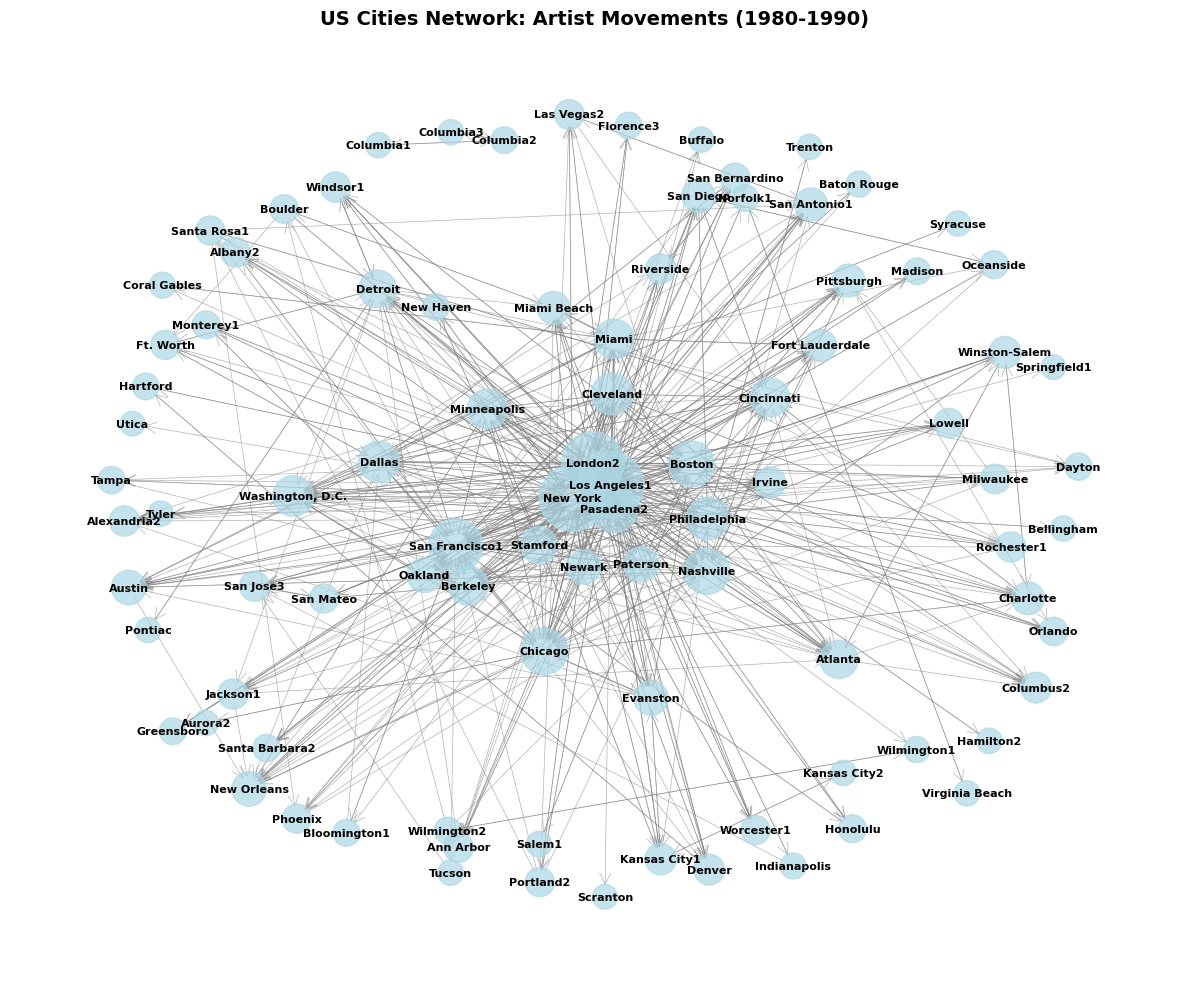


Network Statistics for US (1980-1990):
Number of cities: 92
Number of connections: 725
Network density: 0.087
Top 5 cities by betweenness centrality:
  New York: 0.164
  Los Angeles1: 0.150
  San Francisco1: 0.146
  Chicago: 0.091
  Pasadena2: 0.086


In [ ]:
def country_centrality_graph(df, city_list, country_name, start_year, end_year, plot=True):
    """
    Generate and optionally plot a network graph of cities based on artist movements
    
    Parameters:
    df: DataFrame containing the data
    city_list: List of cities to include in the analysis
    country_name: Name of the country/region for labeling
    start_year: Start year for filtering
    end_year: End year for filtering
    plot: Whether to display the plot
    
    Returns:
    NetworkX DiGraph object
    """
    # Filter data to only include cities in the list
    country_subset = df[df['city'].isin(city_list)]
    
    df_filtered = country_subset[(country_subset['year'] >= start_year) & (country_subset['year'] < end_year)]
    # Group by artist
    artist_groups = df_filtered.groupby('artist_name')

    edges = []

    for artist, group in artist_groups:
        # Sort by year for each artist
        group_sorted = group.sort_values('year')
        cities_years = list(zip(group_sorted['city'], group_sorted['year']))
        # Remove consecutive duplicates (artist in same city in consecutive years)
        for i in range(1, len(cities_years)):
            city_a, year_a = cities_years[i-1]
            city_b, year_b = cities_years[i]
            if city_a != city_b:
                if year_a == year_b:
                    # If same year, count both directions
                    edges.append((city_a, city_b))
                    edges.append((city_b, city_a))
                else:
                    # Direction: from earlier city to later city
                    edges.append((city_a, city_b))

    # Count edge weights
    edge_counts = Counter(edges)

    # Build directed graph
    G = nx.DiGraph()
    for (src, dst), weight in edge_counts.items():
        if src and dst:
            G.add_edge(src, dst, weight=weight)
    
    if not plot or len(G.nodes()) == 0:
        return G
    
    # Create the visualization
    plt.figure(figsize=(12, 10))
    
    # Use spring layout for better visualization
    pos = nx.spring_layout(G, k=2, iterations=50)
    
    # Get edge weights for visualization
    edges = G.edges()
    weights = [G[u][v]['weight'] for u, v in edges]
    
    # Normalize weights for visualization
    if weights:
        max_weight = max(weights)
        min_weight = min(weights)
        norm_weights = [(w - min_weight) / (max_weight - min_weight + 1) * 4 + 0.5 for w in weights]
    else:
        norm_weights = []
    
    # Calculate node sizes based on degree centrality
    node_sizes = []
    if len(G.nodes()) > 0:
        centrality = nx.degree_centrality(G)
        max_centrality = max(centrality.values()) if centrality.values() else 1
        node_sizes = [centrality.get(node, 0) / max_centrality * 2000 + 300 for node in G.nodes()]
    
    # Draw the network
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, 
                          node_color='lightblue', alpha=0.7)
    
    if norm_weights:
        nx.draw_networkx_edges(G, pos, width=norm_weights, 
                              edge_color='gray', alpha=0.6, 
                              arrows=True, arrowsize=20, arrowstyle='->')
    
    # Add labels
    nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')
    
    plt.title(f'{country_name} Cities Network: Artist Movements ({start_year}-{end_year})', 
              fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Print some statistics
    print(f"\nNetwork Statistics for {country_name} ({start_year}-{end_year}):")
    print(f"Number of cities: {len(G.nodes())}")
    print(f"Number of connections: {len(G.edges())}")
    if len(G.nodes()) > 0:
        print(f"Network density: {nx.density(G):.3f}")
        
        # Top cities by betweenness centrality
        betweenness = nx.betweenness_centrality(G, weight='weight')
        top_cities = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:5]
        print(f"Top 5 cities by betweenness centrality:")
        for city, cent in top_cities:
            print(f"  {city}: {cent:.3f}")
    
    return G


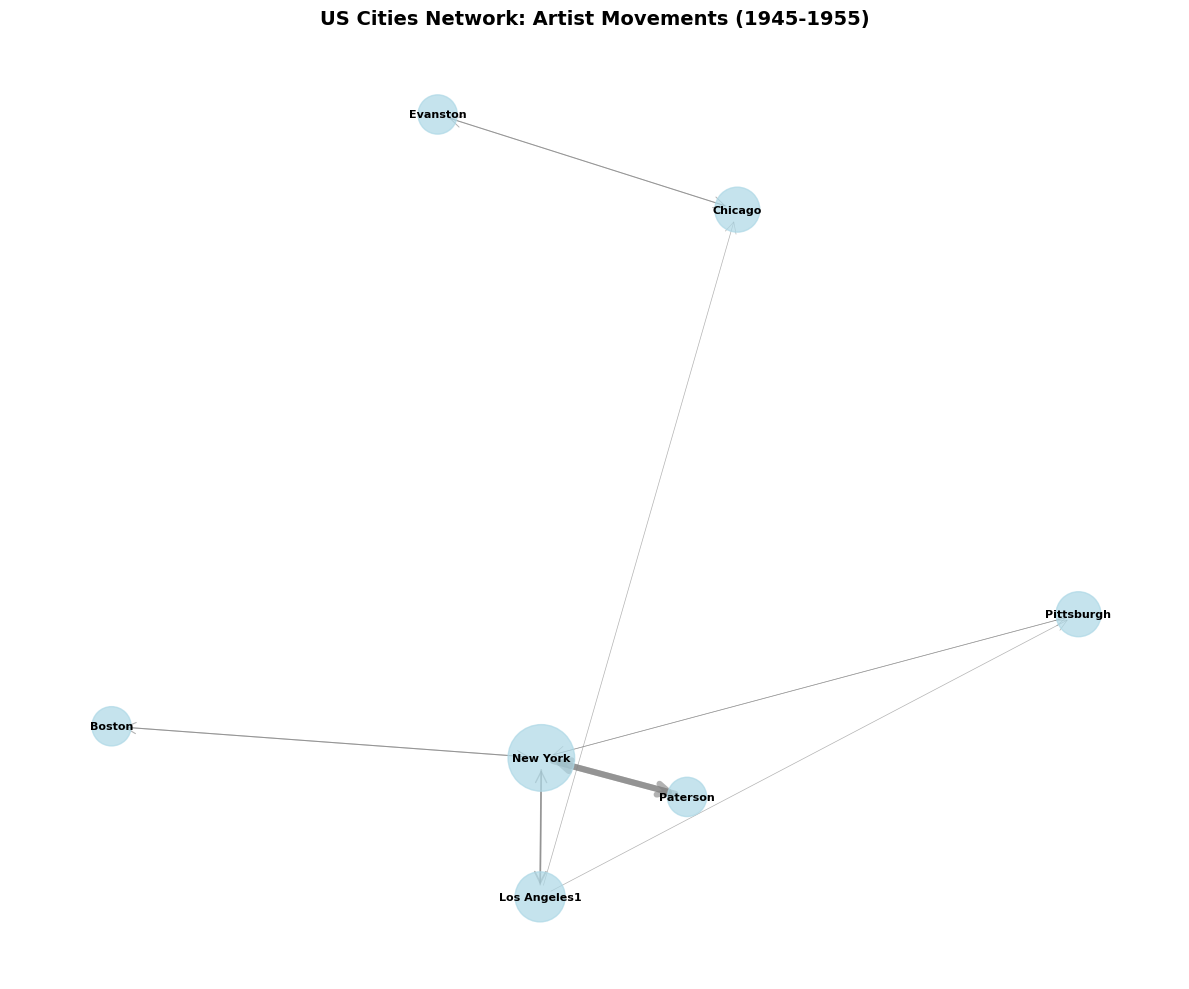


Network Statistics for US (1945-1955):
Number of cities: 7
Number of connections: 12
Network density: 0.286
Top 5 cities by betweenness centrality:
  New York: 0.567
  Los Angeles1: 0.267
  Chicago: 0.167
  Pittsburgh: 0.100
  Paterson: 0.000


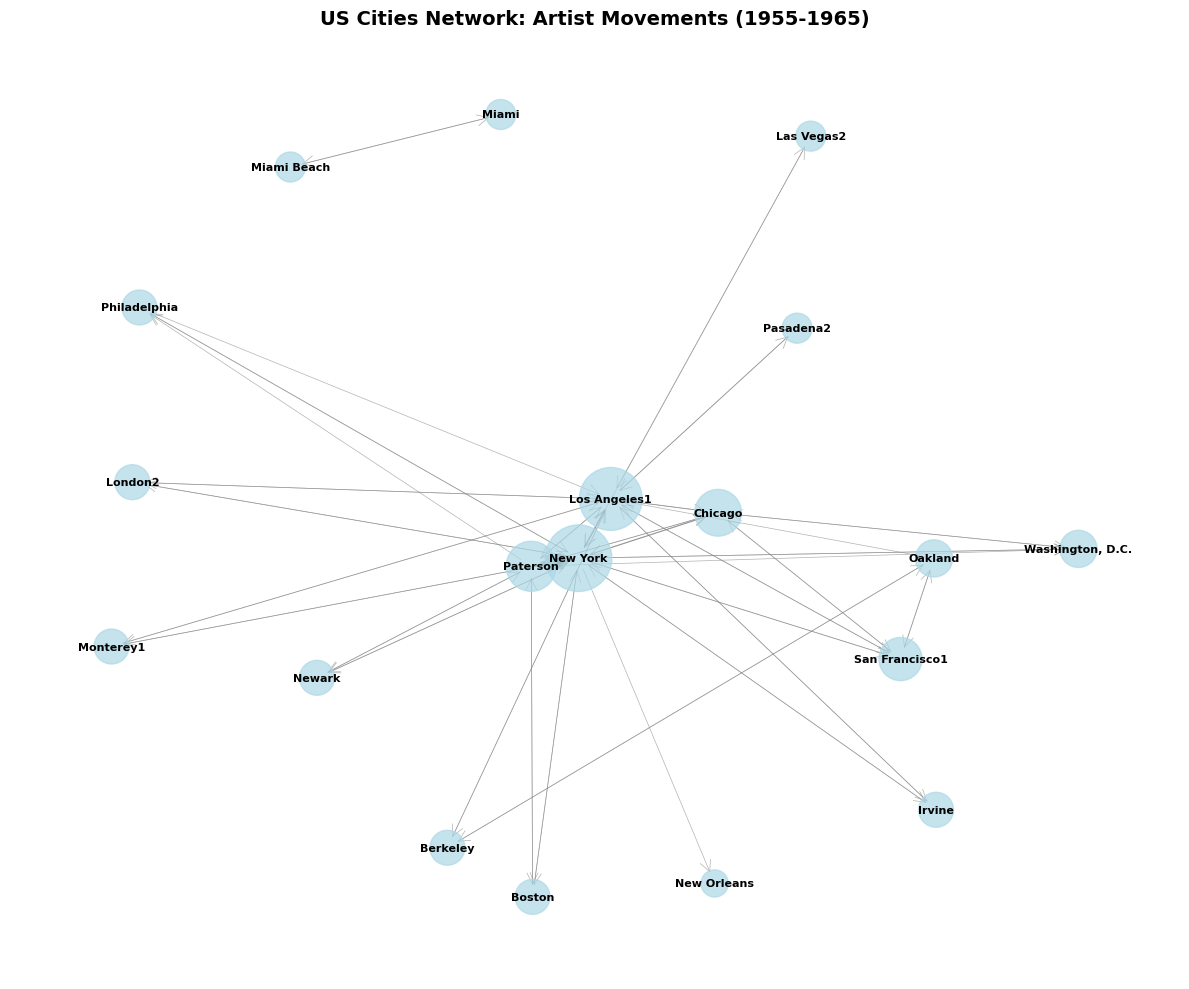


Network Statistics for US (1955-1965):
Number of cities: 19
Number of connections: 61
Network density: 0.178
Top 5 cities by betweenness centrality:
  Los Angeles1: 0.381
  Paterson: 0.253
  New York: 0.224
  Philadelphia: 0.114
  Chicago: 0.103


In [14]:
df_jazz = df[df['genre'] == "Jazz"]
country_centrality_graph(df_jazz, US_cities, "US", 1945, 1955, plot=True)
country_centrality_graph(df_jazz, US_cities, "US", 1955, 1965, plot=True)

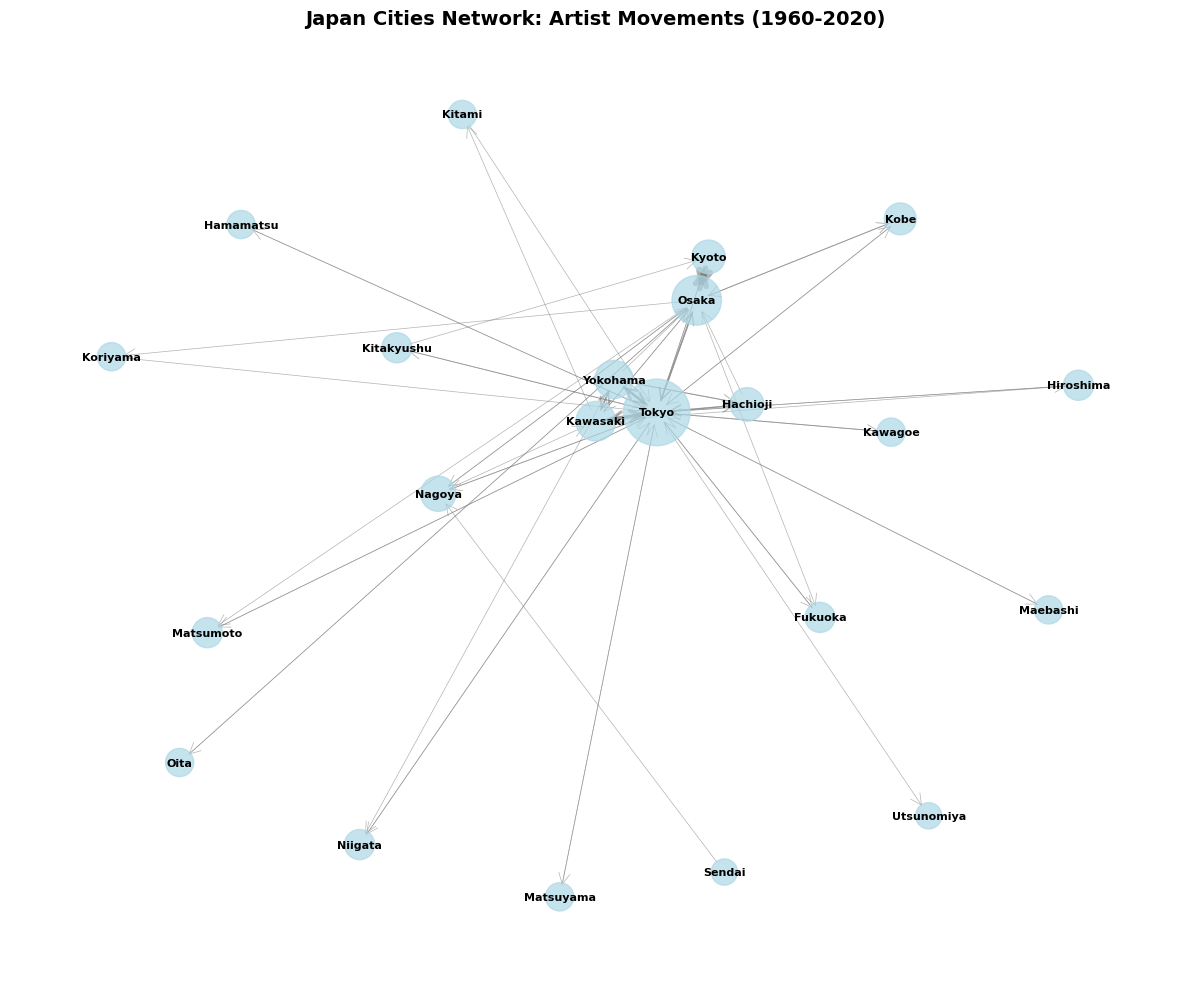


Network Statistics for Japan (1960-2020):
Number of cities: 22
Number of connections: 60
Network density: 0.130
Top 5 cities by betweenness centrality:
  Tokyo: 0.764
  Osaka: 0.221
  Kawasaki: 0.195
  Kitami: 0.131
  Koriyama: 0.112


In [16]:
JAPAN_CITIES = [
    'Kitakyushu', 'Nagoya', 'Osaka', 'Tokyo', 'Kawasaki', 'Sendai',
    'Sapporo', 'Kyoto', 'Hiroshima', 'Hamamatsu', 'Niigata', 'Hachioji',
    'Matsuyama', 'Koriyama', 'Maebashi', 'Utsunomiya', 'Kawagoe',
    'Kitami', 'Matsumoto', 'Nagaoka', 'Shizuoka', 'Yokohama',
    'Fukuoka', 'Kobe', 'Oita'
]

country_centrality_graph(df, JAPAN_CITIES, "Japan", 1960, 2020, plot=True)

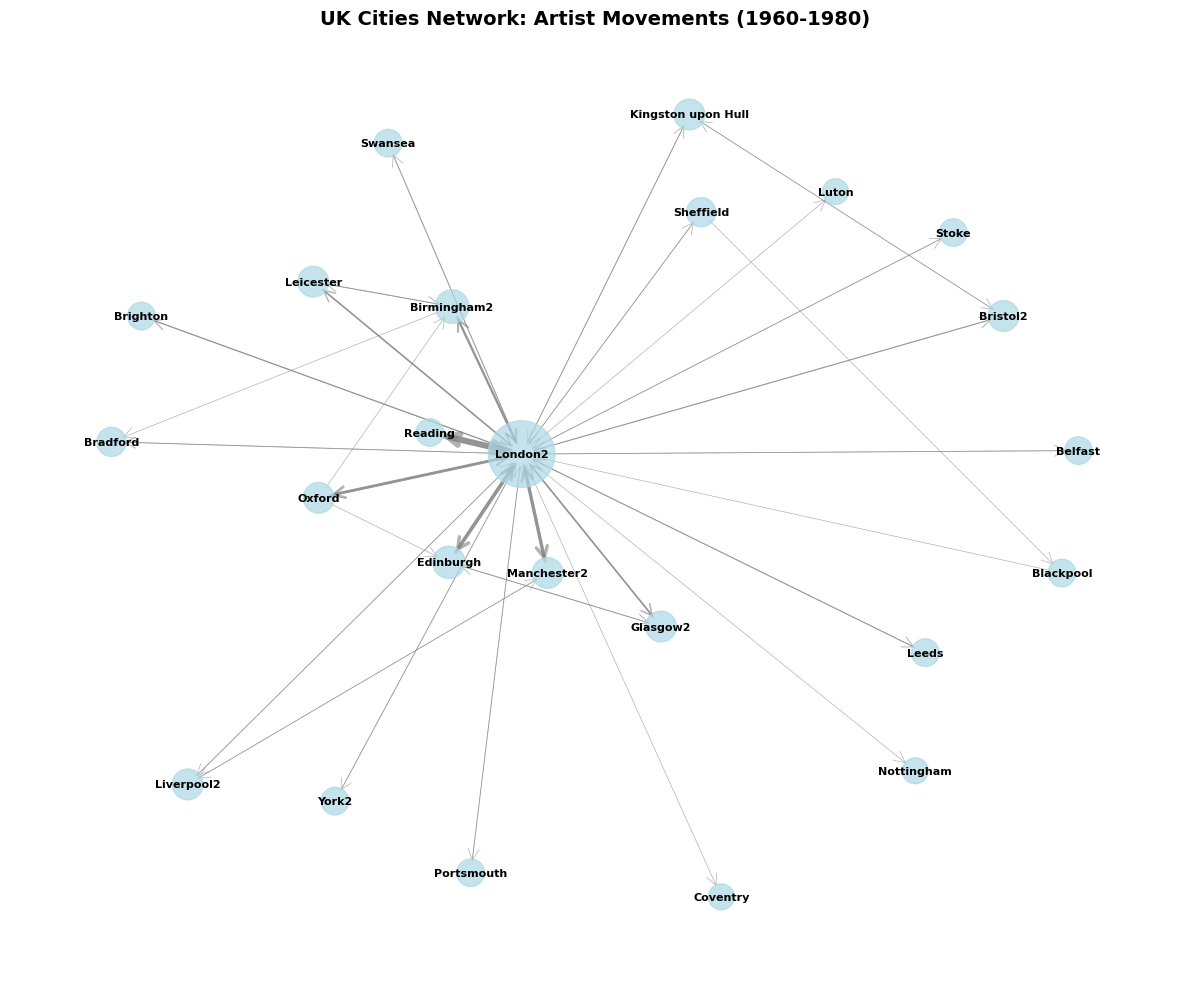


Network Statistics for UK (1960-1980):
Number of cities: 24
Number of connections: 54
Network density: 0.098
Top 5 cities by betweenness centrality:
  London2: 0.838
  Bradford: 0.119
  Birmingham2: 0.083
  Liverpool2: 0.081
  Kingston upon Hull: 0.081


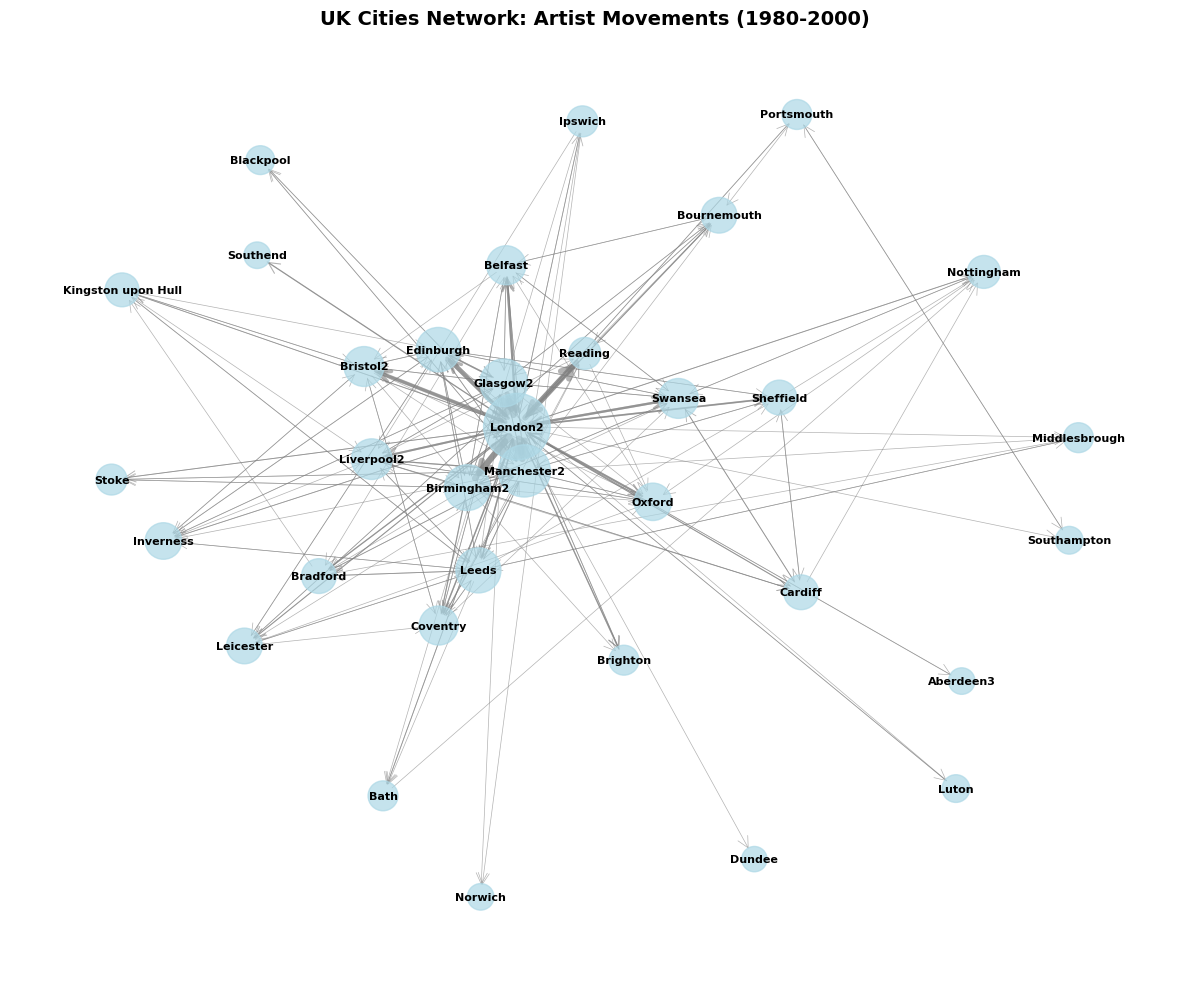


Network Statistics for UK (1980-2000):
Number of cities: 34
Number of connections: 210
Network density: 0.187
Top 5 cities by betweenness centrality:
  London2: 0.254
  Leeds: 0.194
  Manchester2: 0.192
  Birmingham2: 0.138
  Glasgow2: 0.121


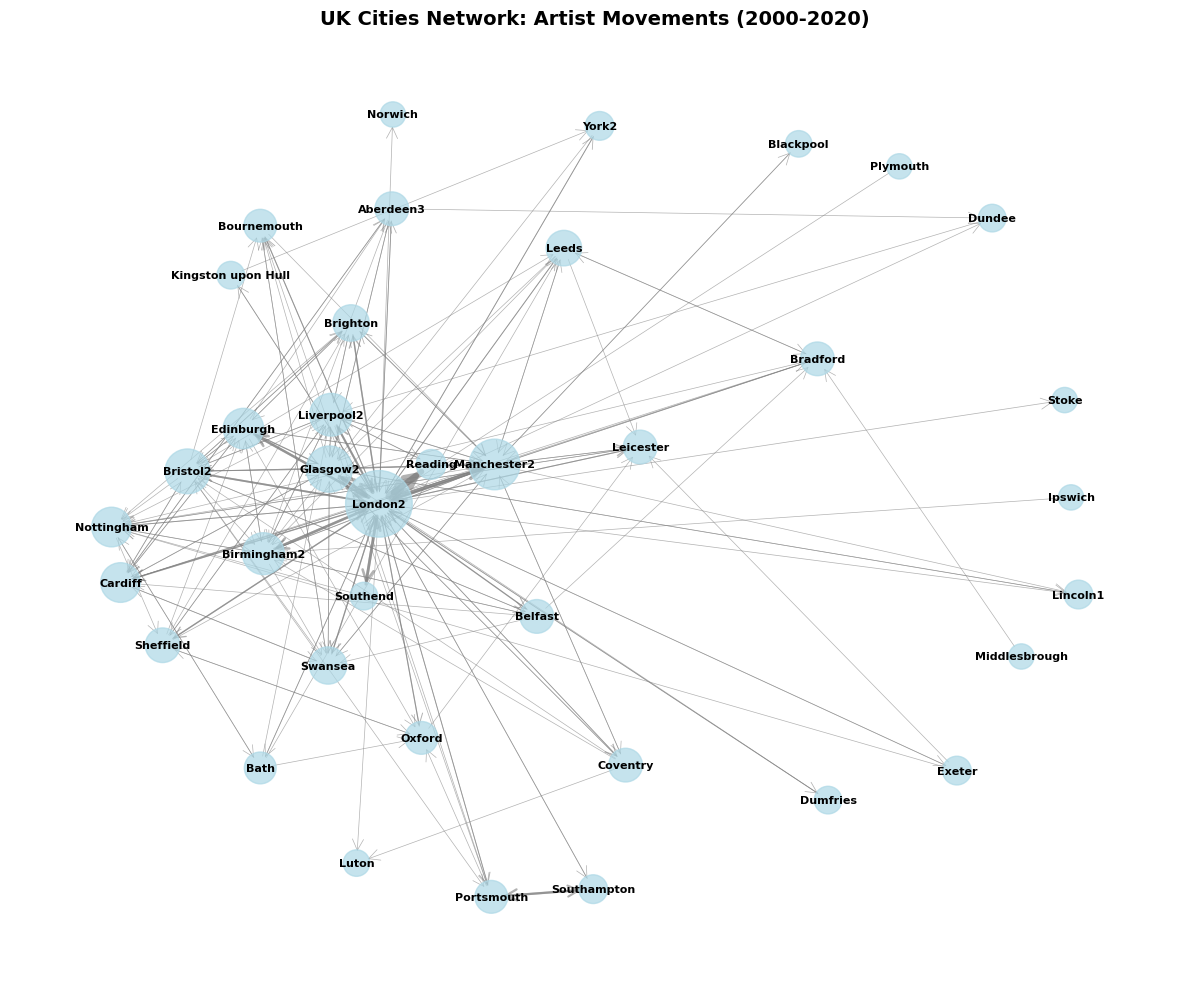


Network Statistics for UK (2000-2020):
Number of cities: 38
Number of connections: 197
Network density: 0.140
Top 5 cities by betweenness centrality:
  Manchester2: 0.261
  London2: 0.252
  Glasgow2: 0.148
  Lincoln1: 0.147
  Nottingham: 0.137


In [18]:
country_centrality_graph(df, UK_CITIES, "UK", 1960, 1980, plot=True)
country_centrality_graph(df, UK_CITIES, "UK", 1980, 2000, plot=True)
country_centrality_graph(df, UK_CITIES, "UK", 2000, 2020, plot=True)